In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [28]:
AQI=pd.read_excel('/content/sample_data/AQI.xlsx')
train=AQI[['Date (YYYY-MM)','Adilabad']].reset_index(drop=True)
train.rename(columns={'Adilabad': 'Air Quality Index (AQI)'}, inplace=True)
train.head()

Date (YYYY-MM) Air Quality Index (AQI)
0     2016-01-01                    67.0
1     2016-02-01                    68.0
2     2016-03-01                    71.0
3     2016-04-01                    70.0
4     2016-05-01                    71.0

In [29]:
train.replace({'Air Quality Index (AQI)':'-'},np.nan,inplace=True)
train=train.astype({'Air Quality Index (AQI)':'float64'})

In [30]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='median')
t2=imputer.fit_transform(train[['Air Quality Index (AQI)']])
train['Air Quality Index (AQI)']=pd.DataFrame(t2)

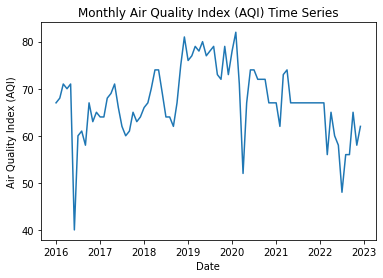

In [31]:
t1=train.set_index('Date (YYYY-MM)')
plt.plot(t1.index,t1['Air Quality Index (AQI)'])
plt.xlabel('Date')
plt.ylabel('Air Quality Index (AQI)')
plt.title('Monthly Air Quality Index (AQI) Time Series')
plt.show()

In [32]:
train.describe()

Air Quality Index (AQI)
count                84.000000
mean                 67.500000
std                   7.435668
min                  40.000000
25%                  64.000000
50%                  67.000000
75%                  72.250000
max                  82.000000

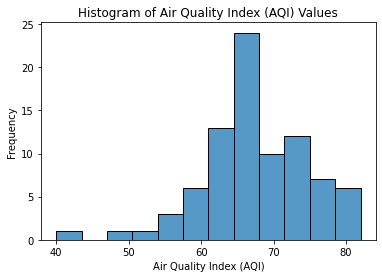

In [33]:
sns.histplot(t1['Air Quality Index (AQI)'],kde=False)
plt.xlabel('Air Quality Index (AQI)')
plt.ylabel('Frequency')
plt.title('Histogram of Air Quality Index (AQI) Values')
plt.show()

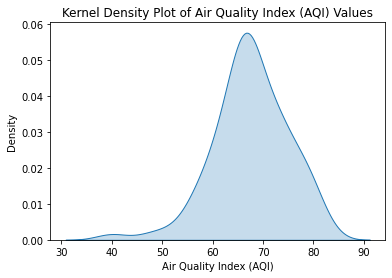

In [34]:
sns.kdeplot(t1['Air Quality Index (AQI)'],shade=True)
plt.xlabel('Air Quality Index (AQI)')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Air Quality Index (AQI) Values')
plt.show()

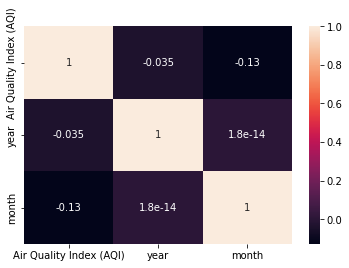

In [35]:
t2=train.copy()
t2['year']=t2['Date (YYYY-MM)'].dt.year
t2['month']=t2['Date (YYYY-MM)'].dt.month
corr_matrix=t2[['Air Quality Index (AQI)', 'year', 'month']].corr()
sns.heatmap(corr_matrix,annot=True)
plt.show()

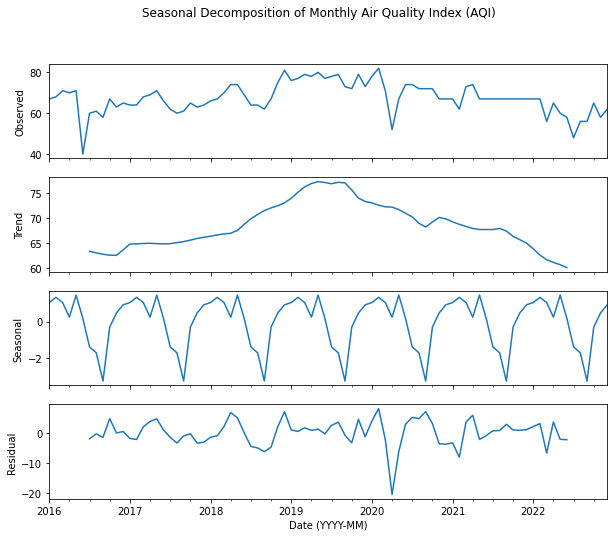

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(t1,model='additive',period=12)
fig,axes=plt.subplots(ncols=1,nrows=4,sharex=True,figsize=(10,8))
decomp.observed.plot(ax=axes[0],legend=False)
axes[0].set_ylabel('Observed')
decomp.trend.plot(ax=axes[1],legend=False)
axes[1].set_ylabel('Trend')
decomp.seasonal.plot(ax=axes[2],legend=False)
axes[2].set_ylabel('Seasonal')
decomp.resid.plot(ax=axes[3],legend=False)
axes[3].set_ylabel('Residual')
plt.suptitle('Seasonal Decomposition of Monthly Air Quality Index (AQI)')
plt.show()

In [37]:
t3=train.copy()
t3.columns=['ds','y']

In [38]:
t4=t3[:-6].reset_index(drop=True)
t_4=t3[-6:].reset_index(drop=True)

In [39]:
def generate_lag(df,n):
    X,y=[],[]
    for i in range(len(df)-n):
        X.append(df[i:i+n])
        y.append(df[n+i])    
    return np.array(X),np.array(y),np.array(y[-n:]).reshape(1,n)

In [40]:
X,y,last_batch_values=generate_lag(t4['y'].values,12)

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,InputLayer,Dropout

In [42]:
def mlp_model(input_,y_,epochs=1000):
    model=Sequential()
    model.add(Dense(64,activation='relu',input_dim=input_.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error',optimizer='adam')
    print(model.fit(input_,y_,epochs=epochs))
    return model

In [43]:
model=mlp_model(X,y,epochs=100)

Epoch 1/100
3/3 [==============================] - 1s 7ms/step - loss: 3767.6221
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 2376.7546
Epoch 3/100
3/3 [==============================] - 0s 6ms/step - loss: 1365.4340
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 769.2881
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 468.7867
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 487.8875
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 702.1129
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: 851.2607
Epoch 9/100
3/3 [==============================] - 0s 6ms/step - loss: 643.8621
Epoch 10/100
3/3 [==============================] - 0s 5ms/step - loss: 474.3289
Epoch 11/100
3/3 [==============================] - 0s 6ms/step - loss: 517.1924
Epoch 12/100
3/3 [==============================] - 0s 5ms/step - loss: 454.6075
Epoch 13/100
3/3 [================

In [44]:
def forecast_function(model,last_batch,n):
    in_value=last_batch.copy()
    preds=[]
    for i in range(n):
        p=model.predict(in_value)
        preds.append(p.ravel())
        in_value=np.append(in_value,p)[1:].reshape(last_batch.shape)
    return np.array(preds).ravel()

In [45]:
pred=forecast_function(model,last_batch_values,6)

1/1 [==============================] - 0s 37ms/step


In [46]:
t_4['Predicted AQI']=pred

In [47]:
def error_function(df,column_1,column_2):
    data=df.copy()
    my_list=[]
    for i in range(len(data)):
        x=(data[column_2][i]*100)/data[column_1][i]
        if x>=100:
            error=x-100
            my_list.append(error)
        else:
            error=100-x
            my_list.append(error)
    data['error_percentage']=my_list
    return data

In [48]:
t4_new=error_function(t_4,'y','Predicted AQI')

In [49]:
def mean_error(df,error_column):
    total=df[error_column].sum()
    mean_error_=total/(len(df))
    return mean_error_

In [50]:
error_rate=mean_error(t4_new,'error_percentage')
error_rate

9.560995575756984

In [51]:
X_r,y_r,last_batch_values_r=generate_lag(t3['y'].values,12)
model_r=mlp_model(X_r,y_r,epochs=50)
pred_r=forecast_function(model_r,last_batch_values_r,12)

Epoch 1/50
3/3 [==============================] - 2s 7ms/step - loss: 8117.2363
Epoch 2/50
3/3 [==============================] - 0s 7ms/step - loss: 5566.4395
Epoch 3/50
3/3 [==============================] - 0s 7ms/step - loss: 3413.9907
Epoch 4/50
3/3 [==============================] - 0s 7ms/step - loss: 2048.9761
Epoch 5/50
3/3 [==============================] - 0s 7ms/step - loss: 1304.0585
Epoch 6/50
3/3 [==============================] - 0s 6ms/step - loss: 852.6290
Epoch 7/50
3/3 [==============================] - 0s 6ms/step - loss: 459.8014
Epoch 8/50
3/3 [==============================] - 0s 6ms/step - loss: 371.7868
Epoch 9/50
3/3 [==============================] - 0s 6ms/step - loss: 365.4421
Epoch 10/50
3/3 [==============================] - 0s 6ms/step - loss: 510.5353
Epoch 11/50
3/3 [==============================] - 0s 6ms/step - loss: 433.7549
Epoch 12/50
3/3 [==============================] - 0s 7ms/step - loss: 381.4636
Epoch 13/50
3/3 [===========================

In [ ]:
pred_r